In [69]:
# define separate function to use recursion
def listComments(artikkel, reg, url, commentList):
    
    print 'requesting: ',url
    page = requests.get(url)
    tree = html.fromstring(page.content)
    comments = tree.xpath('//div[@class="comment-content-inner"]')
    authors = tree.xpath('//div[@class="comment-author"]')
    commentDates = tree.xpath('//div[@class="comment-date"]/text()')
    commentVotesUp = tree.xpath('//div[@class="comment-votes-up"]/a/span[@class="comment-votes-count"]/text()')
    commentVotesDown = tree.xpath('//div[@class="comment-votes-down"]/a/span[@class="comment-votes-count"]/text()')
    commentsPagerNext = tree.xpath('//div[@class="comments-pager comments-pager-top"]/a[@class="comments-pager-arrow-last"]')
    
    #print "pikkused:", len(commentDates),len(comments), len(authors), len(commentVotesUp), len(commentVotesDown), len(commentsPagerNext)
    
    # trüki kõik leitud kommentaarid välja
    for i in range(len(comments)):
        # vote-d on kaks korda miskipärast, seega 
        ii = i * 2 + 1
        
        # puhasta comment erinevast HTML läbust, reavahe jms
        #comment = comments[i]
        comment = h.unescape(html.tostring(comments[i])).replace("</div>", "").replace("<div class=\"comment-content-inner\">", "").strip()
        
        # reavahe asendus
        comment = comment.replace("<br>\n", u'⏎')
        # DELFI spam ära
        comment = comment.replace('<font class="delfiCoB">D</font><font class="delfiCoY">E</font><font class="delfiCoB">LFI</font>', 'DELFI')
        # puhasta autor HTML-ist
        author = h.unescape(html.tostring(authors[i])).replace("</div>", "").replace("<div class=\"comment-author\">", "").replace('<a href="javascript:void(1)" onclick="CommentList.showUserComments(this)">', "").replace("</a>", "").strip()
        
        ts = datetime.strptime(commentDates[i].strip(), '%d.%m.%Y %H:%M')
        
        commentItem = {'artikkel':artikkel, 'reg':reg, 'indx_page':i, 'author': author.encode('utf-8'),'date': ts, 'commentVotesUp': int(commentVotesUp[i].strip()), 'commentVotesDown': int(commentVotesDown[i].strip()), 'comment':  comment.encode('utf-8'),'commentUrl': url}
        commentList.append(commentItem)

    # kui on veel kommentaaride lehti, sisi võta pager-ist URL-id ja päri neid ka, kasutades sama funktsiooni (1-kordne rekursioon)
    for pager in commentsPagerNext: # seal on 1 tegelikult alati vaid, või 0 kui pole järgmist lehekülge
        newUrl = pager.attrib.get('href')
            
        listComments(artikkel, reg, newUrl, commentList) # rekursiivne


In [70]:
# actual loading of comments of a page

from lxml import html
import requests
import HTMLParser
from datetime import datetime


# kommentaari lehe URL
artikkel = "http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1"

# global settings
h = HTMLParser.HTMLParser()

commentList = []

for reg in range(2): # 0 - anon, 1 - registered user
  url = artikkel + "&com=1&reg=%s&no=0&s=1" % (reg)
  listComments(artikkel, reg, url, commentList)


requesting:  http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1&com=1&reg=0&no=0&s=1
requesting:  http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&s=1&no=20
requesting:  http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&s=1&no=40
requesting:  http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&s=1&no=60
requesting:  http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=7

In [72]:
# convert dict list to pandas DataFrame for easier manipulation
import pandas as pd

df = pd.DataFrame(commentList)

# check data: structure/fields, and first rows
df.head()
df.dtypes

artikkel                    object
author                      object
comment                     object
commentUrl                  object
commentVotesDown             int64
commentVotesUp               int64
date                datetime64[ns]
indx_page                    int64
reg                          int64
dtype: object

In [73]:
# calculate total votes
df['totalVotes'] = df.commentVotesDown + df.commentVotesUp

# show top comments by number of total votes
dfSorted = df.sort_values(by='totalVotes', ascending=False)

pd.options.display.max_colwidth = 500 # otherwise texts are shortened
dfSorted.head()

,artikkel,author,comment,commentUrl,commentVotesDown,commentVotesUp,date,indx_page,reg,totalVotes
421,http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1,andres.,"Hillary Clinton oli omal ajal Valges majas Billy pihta lampe loopinud . Ilmselt on ka Rõivase majapidamises lambid otsa saanud. ⏎⏎Juudipoiss marsib stuudiosse ähvardav ilme näol! Ta on valmis kogu maailmale tõestama. Soonvald kinnitab ,et ohvri sõnul oli Taavike üritanud asju mida trükimust ei kannata, suudlemine oli lihtsalt eelmäng. Mine võta kinni... ⏎⏎Igal juhul selge on üks- süüdi on EKRE!",http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1&com=1&reg=1&no=0&s=1,20,482,2017-10-13 12:25:00,14,1,502
411,http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1,aivo Peterson,Perekond”Clintonid” marsivalt uhkel kaamerate valgusesse ja Eesti eliidi/libaeliidi etalon?,http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1&com=1&reg=1&no=0&s=1,26,443,2017-10-13 00:10:00,4,1,469
7,http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1,"Ühest tantsust nii suur jama,kui ma poleks tahtnud tantsida poleks seda teinud.","Ta räägib igalpool oma päheõpitud lauseid.⏎Ta ei kuule isegi küsimust.Iga inimene saab aru,et tantsust üksi ei tule ahistamis süüdistust.Siis oleks terve Eesti kohtu all.",http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1&com=1&reg=0&no=0&s=1,22,442,2017-10-12 22:27:00,7,0,464
427,http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1,aivo Peterson,"Nojah,,, meil promotakse vargaid ja perverte.. peaasi, et oleks reformierakonnast...⏎värd peaks kongis olema,, mitte telekas esinema..⏎koos luisaga maksumaksja rahaga välismaal läbutamas ja ahistamas... ⏎elagu reformierakond ,,kindlalt edasi----------⏎Võid kindel olla, kui riiki juhivad sellised ajud, nagu sellel taavil , siis on pervetide ja varaste pidupäev..",http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1&com=1&reg=1&no=0&s=1,36,309,2017-10-12 22:38:00,20,1,345
409,http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1,Käsnajulle,"Tahaks nüüd küsida ajaloolaste käest, et kuidas tulevikus Eesti ajalugu kirjutatakse. Kas asespiiker tegi peenhäälestust Malaisias, mida temal Eestis ei õnnestunud. Peale sündmusi eitas asju ja tegeles oma puhtaks peasemisega. Jätkab riigikogulasena, et jällegi teha kuskil peenhäälestust.",http://publik.delfi.ee/news/inimesed/video-blogi-ja-fotod-luisa-roivas-oma-abikaasa-umber-lahvatanud-ahistamisskandaalist-olen-hairitud-ja-taavis-pettunud?id=79814146&com=1&reg=0&no=0&s=1&com=1&reg=1&no=0&s=1,20,318,2017-10-12 22:57:00,2,1,338


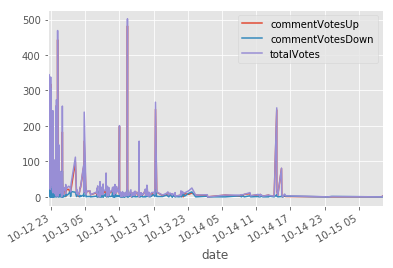

In [63]:
# print graph for comment votes over time. 
# Not sure how to interpret this really

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

df.plot(x='date', y=['commentVotesUp','commentVotesDown','totalVotes'])